# Transfermarkt Transfers

**Disclaimers** : 
- The analysis scope is based on the dataset, especially on the defined transfer date range. Some info and numbers may differ from the real complete data out there.
- Some data may be missing because of scraping issue or restricted by the transfermarkt themselves. These could causing an innacurate conclusions.

The dataset was politely scraped from [transfermarkt.com](https://www.transfermarkt.com/statistik/transfertage) using Scrapy and Splash. The notebook will be updated as the scraping goes from time to time. Check the `Transfer Date Range` section below to find out the oldest and latest date.

## Preparation

### Import Libraries

In [38]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
import datetime
from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


python version:  3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas version:  1.1.3
seaborn version:  0.11.0
last run:  2021-11-24 00:22:19


### Loading Dataset

In [39]:
df = pd.read_csv("transfermarkt-transfer.csv")

# developer-friendly column names and format
df.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in df.columns.to_list()]

## Dataset Information & Description

### Data Sample

In [40]:
df.sample(10, random_state=1)

,player_id,name,age,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,market_value_p,fee,left_club_country,joined_club_country,loan_fee,loan_fee_p,created_at,updated_at
44299,560422.0,Lazar Vukovic,22.0,Left-Back,Serbia,NaN,IMT Belgrad,Prva liga Srbije,FK Alfa Modriča,Prva Liga RS,"Mar 5, 2021",2021-03-05,€25Th.,25000,free transfer,Serbia,Bosnia-Herzegovina,NaN,NaN,2021-11-17 00:14:23,2021-11-17 00:14:23
20553,201696.0,Floriano Vanzo,26.0,Attacking Midfield,Belgium,Italy,RE Virton,2de Nationale ACFF,ACSM Poli Iasi,Liga 1 - Relegation group,"Aug 29, 2020",2020-08-29,€300Th.,300000,free transfer,Belgium,Romania,NaN,NaN,2021-10-04 17:06:58,2021-10-04 17:06:58
26774,234764.0,Nuno Campos,27.0,Right-Back,Portugal,NaN,Nacional,Liga Bwin,Mafra,Liga Portugal 2,"Jul 16, 2020",2020-07-16,€150Th.,150000,-,Portugal,Portugal,NaN,NaN,2021-10-04 17:37:45,2021-10-04 17:37:45
11150,383456.0,Cinar Tarhan,23.0,Central Midfield,Turkey,NaN,C. Rizespor,Süper Lig,Ergene Velimese,2.Lig Beyaz,"Sep 15, 2020",2020-09-15,€50Th.,50000,loan transfer,Turkey,Turkey,NaN,NaN,2021-10-04 16:38:28,2021-10-04 16:38:28
28550,110874.0,Kazuma Watanabe,34.0,Centre-Forward,Japan,NaN,Gamba Osaka,J1 League,Yokohama FC,J1 League,"Jan 9, 2021",2021-01-09,€475Th.,475000,free transfer,Japan,Japan,NaN,NaN,2021-10-24 21:33:37,2021-10-24 21:33:37
835,330879.0,Sedat Dursun,23.0,Defensive Midfield,Turkey,NaN,Bursaspor,1.Lig,Without Club,NaN,"Dec 2, 2020",2020-12-02,€100Th.,100000,-,Turkey,NaN,NaN,NaN,2021-10-04 14:12:27,2021-10-04 14:12:27
36572,275159.0,Mikhail Kostyukov,29.0,Right Winger,Russia,NaN,Tambov,Premier Liga,Rubin Kazan,Premier Liga,"Feb 1, 2021",2021-02-01,€800Th.,800000,free transfer,Russia,Russia,NaN,NaN,2021-11-02 12:51:17,2021-11-02 12:51:17
28677,221578.0,Mihael Orachev,25.0,Left-Back,Bulgaria,NaN,CSKA 1948,efbet Liga,PFC Montana,efbet Liga,"Jan 15, 2021",2021-01-15,€150Th.,150000,free transfer,Bulgaria,Bulgaria,NaN,NaN,2021-10-24 21:33:50,2021-10-24 21:33:50
26132,615303.0,Mateja Stojanovic,19.0,Central Midfield,Serbia,NaN,Red Star U19,Omladinska liga,Zarkovo,Prva liga Srbije,"Jul 14, 2020",2020-07-14,€100Th.,100000,loan transfer,Serbia,Serbia,NaN,NaN,2021-10-04 17:36:50,2021-10-04 17:36:50
31840,188312.0,Ramin Rezaeian,30.0,Right-Back,Iran,NaN,Al-Duhail SC,Stars League,Al-Sailiya SC,Stars League,"Jan 1, 2021",2021-01-01,€500Th.,500000,loan transfer,Qatar,Qatar,NaN,NaN,2021-10-24 21:44:41,2021-10-24 21:44:41


### Columns Description

| Column | Description | Data Type |
| --- | ----------- | ------- |
| player_id | The player's ID in transfermarkt site | categorical - unique |
| name | The player's name | categorical - nominal |
| age | The player's age | numerical - discrete |
| position | The player's position | categorical - nominal |
| national_1 | The player's nationality | categorical - nominal |
| national_2 | The player's other nationality | categorical - nominal |
| left_club | the player's former club | categorical - nominal |
| left_club_league | the player's former club league | categorical - nominal |
| left_club_country | the player's former club country | categorical - nominal |
| join_club | the player's new club | categorical - nominal |
| join_club_league | the player's new club league | categorical - nominal |
| join_club_country | the player's new club country | categorical - nominal |
| transfer_date | the transfer date | categorical - nominal |
| transfer_date_p | the transfer date (parsed) | categorical - date |
| market_value | the player's market value | categorical - nominal |
| market_value_p | the player's market value (parsed) | numerical - discrete |
| fee | - | categorical - nominal |
| loan_fee | - | categorical - nominal |
| loan_fee_p | - | numerical - discrete |
| created_at | the time data created (scraped) | categorical - datetime |
| updated_at | the time data edited (after scraped) | categorical - datetime |


### Data Information

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45441 entries, 0 to 45440
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            44388 non-null  float64
 1   name                 45441 non-null  object 
 2   age                  45207 non-null  float64
 3   position             45441 non-null  object 
 4   national_1           45440 non-null  object 
 5   national_2           6985 non-null   object 
 6   left_club            44485 non-null  object 
 7   left_club_league     32805 non-null  object 
 8   joined_club          43923 non-null  object 
 9   joined_club_league   31884 non-null  object 
 10  transfer_date        45441 non-null  object 
 11  transfer_date_p      45441 non-null  object 
 12  market_value         45441 non-null  object 
 13  market_value_p       45441 non-null  int64  
 14  fee                  45438 non-null  object 
 15  left_club_country    41612 non-null 

### Transfers Date Range

In [42]:
print(f"from {df.sort_values(['transfer_date_p']).iloc[[0, -1]].values[0, 10]} to {df.sort_values(['transfer_date_p']).iloc[[0, -1]].values[1, 10]}")

from Jul 4, 2020 to Mar 16, 2021


## Preprocessing

### Find and Handle Missing Values

In [43]:
idf = df.isna().sum().reset_index().rename({'index': 'column', 0: 'missing'}, axis=1)
idf['percentage'] = round(idf['missing'] / df.shape[0], 2)
idf

,column,missing,percentage
0,player_id,1053,0.02
1,name,0,0.00
2,age,234,0.01
3,position,0,0.00
4,national_1,1,0.00
5,national_2,38456,0.85
6,left_club,956,0.02
7,left_club_league,12636,0.28
8,joined_club,1518,0.03
9,joined_club_league,13557,0.30


- `player_id` is a unique value, we don't need to fill the blank and remove the feature later.
- `age` has a little amount of missing data. We could fill them with median value.
- `national_1`, `fee` has pieces of missing data. We could drop the value.
- `national_2`, `left_club_league`, `joined_club_league`, `loan_fee`, `loan_fee_p` has large amount of missing data. We could remove these features later.

In [44]:
df['age'].fillna(df['age'].median(), inplace=True)
df.dropna(subset=['national_1', 'fee'], inplace=True)

### Remove Unnecessary Features

`player_id`, `created_at` and `updated_at` are less relevant for analysis. `market_value` and `transfer_date` has the parsed version of the values. So we will remove these features.

In [45]:
features_tobe_removed = ['player_id', 'market_value', 'transfer_date', 'created_at', 'updated_at', 'national_2', 'loan_fee', 'loan_fee_p']

df.drop(features_tobe_removed, axis=1, inplace=True)

### Remove Duplication

In [46]:
print("before removal:", df.shape[0])

print("duplicated count:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

print("after removal:", df.shape[0])

before removal: 45437
duplicated count: 748
after removal: 44689


### Casting Dtypes

In [47]:
df = df.astype({
    "age": int
})

### Preprocesed Data Sample

In [48]:
df.sample(5, random_state=1)

,name,age,position,national_1,left_club,left_club_league,joined_club,joined_club_league,transfer_date_p,market_value_p,fee,left_club_country,joined_club_country
196,Gianluca Reale,19,Centre-Back,Italy,Sorrento,Serie D - H,Puteolana,Serie D - H,2020-12-12,50000,free transfer,Italy,Italy
24116,Sergey Mosiyan,17,Left Winger,Russia,Khimki 2,FNL-2 Group 3,Khimki II,U19 M-Liga,2020-08-01,25000,-,Russia,Russia
22099,Firatcan Üzüm,21,Left Winger,Turkey,Trabzonspor,Süper Lig,Trabzonspor U19,U19 Süper Lig,2020-08-04,150000,-,Turkey,Turkey
41684,Diego García,31,Goalkeeper,Spain,Without Club,NaN,Vestri,Lengjudeild,2021-02-18,150000,-,NaN,Iceland
23908,Richard Addai,29,Centre-Forward,Ghana,Dreams FC,Premier League,Without Club,NaN,2020-08-01,25000,-,Ghana,NaN


## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [49]:
df.select_dtypes(include='number').describe()

,age,market_value_p
count,44689.000000,4.468900e+04
mean,25.498736,3.716306e+05
std,4.665916,1.688889e+06
min,15.000000,1.000000e+04
25%,22.000000,5.000000e+04
50%,25.000000,1.000000e+05
75%,29.000000,2.500000e+05
max,45.000000,8.100000e+07


#### Categorical

In [50]:
df.select_dtypes(exclude='number').describe()

,name,position,national_1,left_club,left_club_league,joined_club,joined_club_league,transfer_date_p,fee,left_club_country,joined_club_country
count,44689,44689,44689,43923,32184,43369,31253,44689,44689,40886,40458
unique,37738,16,202,6784,322,7258,340,256,393,160,164
top,Dudu,Centre-Forward,Italy,Without Club,Premier League,Without Club,Premier League,2020-08-01,free transfer,Italy,Italy
freq,14,7123,3989,3483,933,3298,726,2062,22601,4395,4509


### Univariate Analysis

#### Distribution Plot of Numerical Features

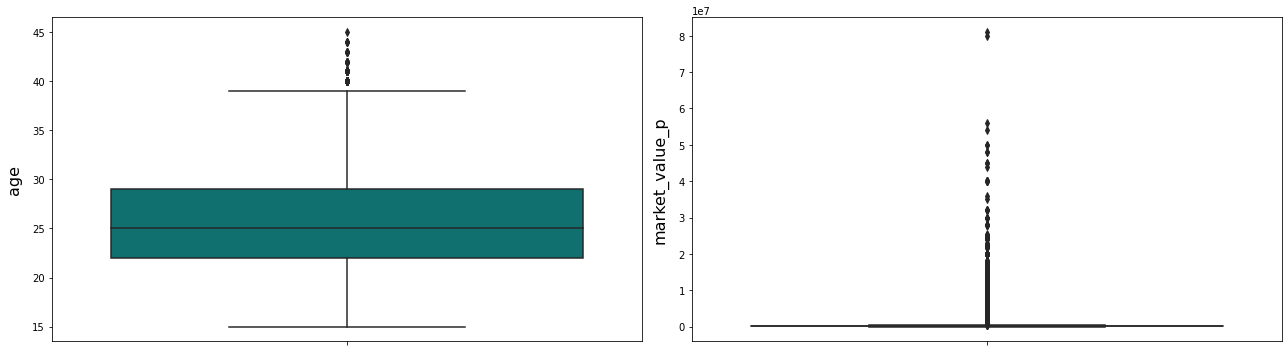

In [51]:
idf = df.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=df[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();


#### Count Plot For Categorical Features

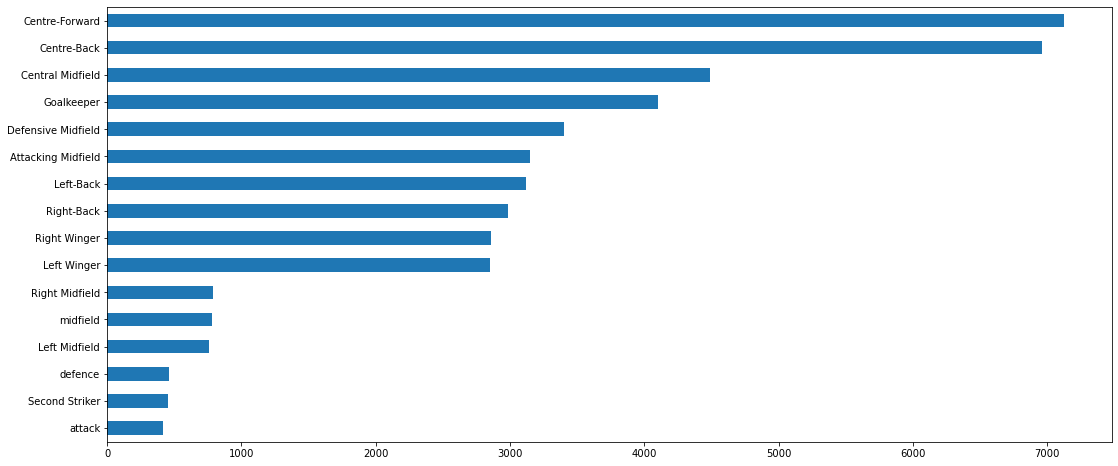

In [83]:
plt.figure(figsize=(18,8))
df['position'].value_counts(ascending=True).plot(kind="barh")
plt.show();

### Multivariate Analysis

#### Correlation Heatmap

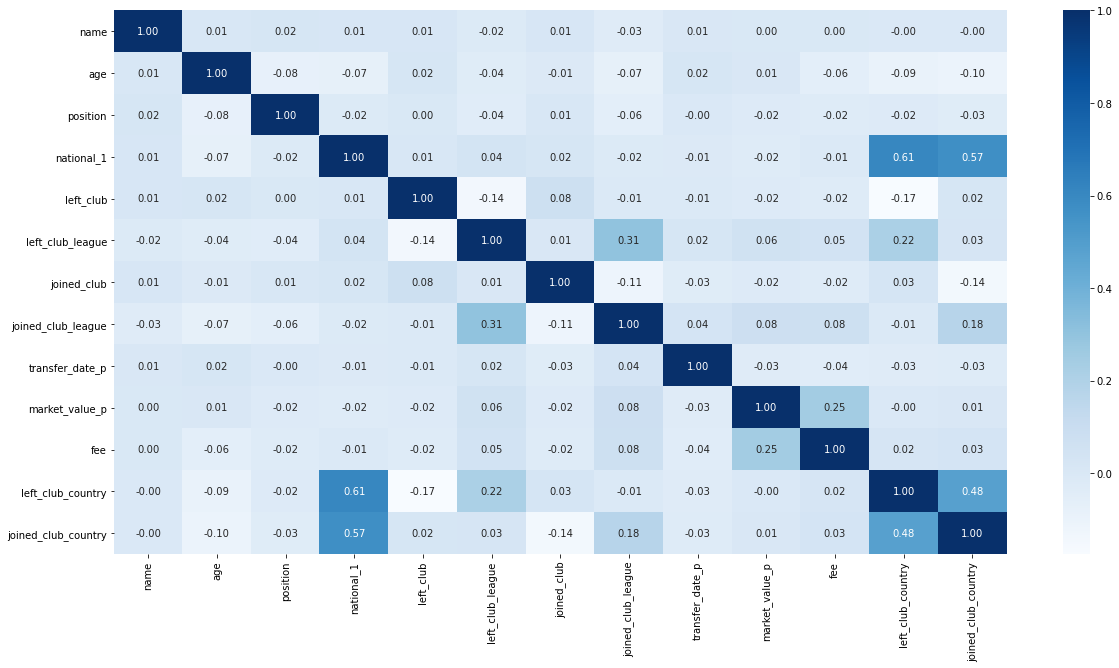

In [53]:
# label encoding for heatmap
edf = df.copy()
for feature in edf.select_dtypes(include='object').columns.tolist():
    edf[feature] = edf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(edf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();


#### Pairplot

### Insights

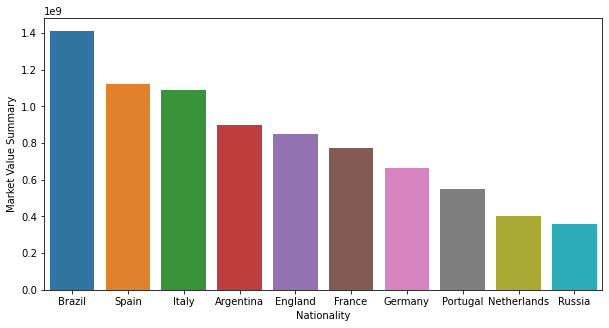

In [55]:
idf = df.groupby('national_1').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='national_1', y='market_value_p', data=idf)
plt.ylabel('Market Value Summary')
plt.xlabel('Nationality')
plt.show();

#### Most Valueable League by Player Transfers

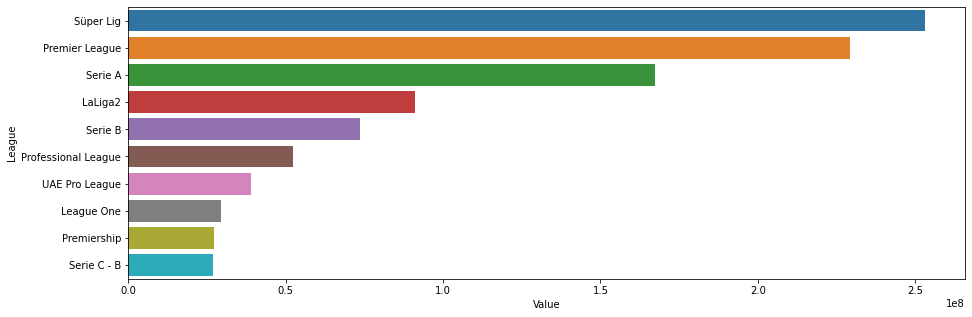

In [56]:
idfl = df.groupby('left_club_league').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index()
idfl = idfl.rename(columns={'left_club_league': 'league','market_value_p': 'out_value'})

idfr = df.groupby('joined_club_league').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index()
idfr = idfr.rename(columns={'joined_club_league': 'league', 'market_value_p': 'in_value'})

idf = idfl.merge(idfr, on='league')
idf['diff_value'] = idf['in_value'] - idf['out_value']
idf = idf.sort_values(['diff_value'], ascending=False).head(10)

plt.figure(figsize=(15, 5))
sns.barplot(x='diff_value', y='league', data=idf)
plt.ylabel('League')
plt.xlabel('Value')
plt.show();


#### Most Valueable Club by Player Transfers

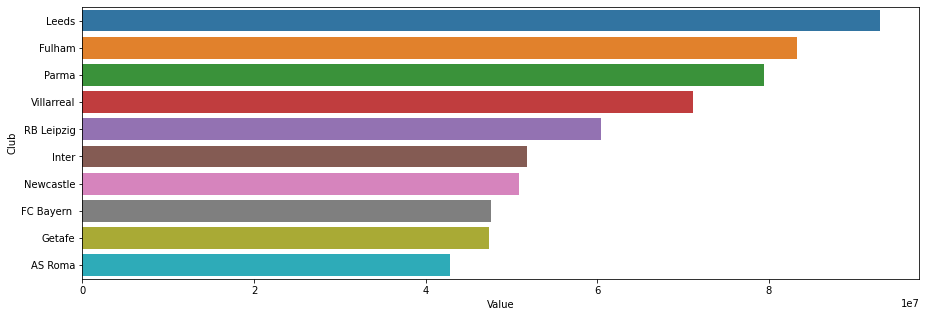

In [57]:
idfl = df.groupby('left_club').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index()
idfl = idfl.rename(columns={'left_club': 'club','market_value_p': 'out_value'})
idfl

idfr = df.groupby('joined_club').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index()
idfr = idfr.rename(columns={'joined_club': 'club', 'market_value_p': 'in_value'})
idfr

idf = idfl.merge(idfr, on='club')
idf['diff_value'] = idf['in_value'] - idf['out_value']
idf = idf.sort_values(['diff_value'], ascending=False).head(10)
idf

plt.figure(figsize=(15, 5))
sns.barplot(x='diff_value', y='club', data=idf)
plt.ylabel('Club')
plt.xlabel('Value')
plt.show();


#### Most Valueable Country by Player Transfers

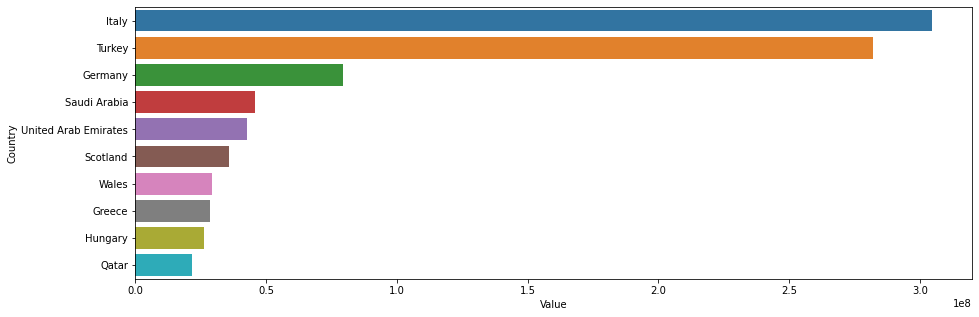

In [58]:
idfl = df.groupby('left_club_country').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index()
idfl = idfl.rename(columns={'left_club_country': 'country','market_value_p': 'out_value'})
idfl

idfr = df.groupby('joined_club_country').agg({'market_value_p': 'sum'}).sort_values('market_value_p', ascending=False).reset_index()
idfr = idfr.rename(columns={'joined_club_country': 'country', 'market_value_p': 'in_value'})
idfr

idf = idfl.merge(idfr, on='country')
idf['diff_value'] = idf['in_value'] - idf['out_value']
idf = idf.sort_values(['diff_value'], ascending=False).head(10)
idf

plt.figure(figsize=(15, 5))
sns.barplot(x='diff_value', y='country', data=idf)
plt.ylabel('Country')
plt.xlabel('Value')
plt.show();


#### Top Transfers

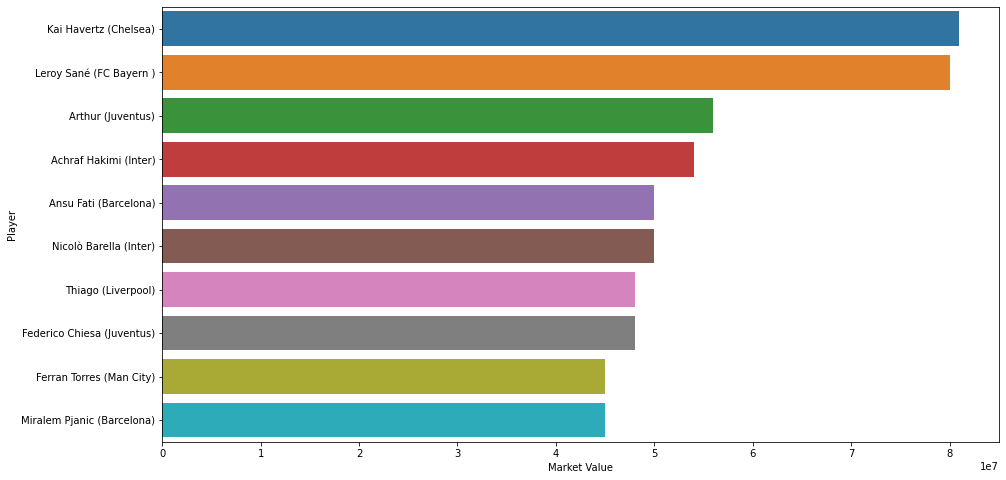

In [59]:
# TODO
idf = df.sort_values('market_value_p', ascending=False).head(10)
idf['name_club'] = idf['name'] + " (" + idf['joined_club'] + ")"

plt.figure(figsize=(15, 8))
sns.barplot(x='market_value_p', y='name_club', data=idf)
plt.ylabel('Player')
plt.xlabel('Market Value')
plt.show();
